# Time Series Analysis and Forecasting

### Task 3:

У вас есть архив с данными по производству электроэнергии ветряными мельницами в Германии. Вам необходимо исследовать временной ряд, описать основные статистики для временного ряда, сделать вывод по временному ряду и сформировать исследовательский отчет подкрепленный соответствующими выводами. 

Необходимо выбрать модель для прогноза временного ряда, объяснить почему именно была выбрана данная модель, объяснить на каком основании. Сделайте прогноз по производству электроэнергии <b>на 1 год вперед</b>, измерить метрику качества. Оформить исследование в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильное и качественно выполненное задание <b>4 балла</b>. 



<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Dataset</h4>
</div>

In [1]:
import pandas as pd

In [2]:
file_path = 'data.csv'
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [4]:
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


Преобразуем dt в формат datetime.

In [5]:
df['dt'] = pd.to_datetime(df['dt'])

In [6]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

В файле 'data.csv' содержится 385566 строк и два столбца:
 - dt — дата и время,
 - MW — числовое значение, вероятно, мощность в мегаваттах.
<br>Пропущенных значений нет, дубликатов нет.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Anomaly detection</h4>
</div>

In [7]:
# Проверим временные интервалы 
# Посчитаем разницу между соседними временными метками
df['dt'].diff().value_counts()

0 days 00:15:00    385497
0 days 00:00:00        50
0 days 01:15:00        11
0 days 00:30:00         6
0 days 00:45:00         1
Name: dt, dtype: int64

In [8]:
c

<br>В основном интервал между записями равен 15 минутам — 385566 случаев.
<br>
<br>Аномалии:
 - Есть 50 записей, где разница между метками 0 минут — это подозрительно и может указывать на дублирование времени без дублирования строки.
 - 1 час 15 минут (11 раз), 30 минут (6 раз), 45 минут (1 раз) - Это может указывать на пропущенные или неправильно записанные временные точки.

In [9]:
duplicates_df = df[df.index.duplicated(keep=False)]

In [10]:
duplicates_df

,MW
dt,
2011-10-30 02:00:00,1034.00
2011-10-30 02:00:00,1159.00
2011-10-30 02:15:00,1012.00
2011-10-30 02:15:00,1110.00
2011-10-30 02:30:00,1078.00
...,...
2021-10-31 02:15:00,7905.88
2021-10-31 02:30:00,7359.39
2021-10-31 02:30:00,7831.52


Изветсно, что в Германии действует следующая система перехода на летнее/зимнее время:
<br>Переход на летнее время:
 - последнее воскресенье марта
 - в 2:00 ночи часы переводятся вперёд на 1 час (на 3:00).
<br>Переход на зимнее время:
 - последнее воскресенье октября
 - в 3:00 ночи часы переводятся назад на 1 час (на 2:00).
<br>Переделаем:

In [11]:
import pandas as pd
import numpy as np
import calendar

In [12]:
# Загрузка данных
df = pd.read_csv(file_path)
df['dt'] = pd.to_datetime(df['dt'])
df['dt_backup'] = df['dt']

In [13]:
# Найти даты перехода на зимнее время
years = df['dt_backup'].dt.year.dropna().unique()
winter_transition_dates = []
for year in years:
    last_october_day = pd.Timestamp(year, 10, calendar.monthrange(year, 10)[1])
    last_sunday = last_october_day - pd.Timedelta(days=(last_october_day.weekday() - 6) % 7)
    winter_transition_dates.append(last_sunday)

winter_transition_dates = pd.to_datetime(winter_transition_dates)

In [14]:
# Добавить колонку с датами
df['date_only'] = df['dt_backup'].dt.normalize()

In [15]:
# Делим на переходные и обычные записи
transition_mask = df['date_only'].isin(winter_transition_dates) & (df['dt_backup'].dt.hour == 2)
df_transition = df[transition_mask].copy()
df_non_transition = df[~transition_mask].copy()

In [16]:
# разметка ambiguous для переходных записей
ambiguous_flags = []

for date in df_transition['date_only'].unique():
    subset = df_transition[df_transition['date_only'] == date].sort_values('dt_backup')
    last_time = None

    for time in subset['dt_backup']:
        if last_time is not None and time == last_time:
            # Вторая встреча времени (дублирование) — зимнее время
            ambiguous_flags.append(False)
        else:
            # Первая встреча времени — летнее время
            ambiguous_flags.append(True)
        last_time = time

In [17]:
# Локализуем переходные записи
df_transition['dt_utc'] = df_transition['dt_backup'].dt.tz_localize(
    'Europe/Berlin',
    ambiguous=ambiguous_flags,
    nonexistent='shift_forward'
).dt.tz_convert('UTC')

In [18]:
# Локализуем остальные записи
df_non_transition['dt_utc'] = df_non_transition['dt_backup'].dt.tz_localize(
    'Europe/Berlin',
    ambiguous='raise',
    nonexistent='shift_forward'
).dt.tz_convert('UTC')

In [19]:
# Объединяем всё вместе
df_final = pd.concat([df_transition, df_non_transition])
df_final = df_final.sort_values('dt_utc')
df = df_final.set_index('dt_utc')[['MW']]

In [20]:
# Проверка дубликатов
duplicates = df[df.index.duplicated(keep=False)]
print("Найдено дубликатов:", len(duplicates))

Найдено дубликатов: 12


In [21]:
duplicates

,MW
dt_utc,
2014-04-07 01:15:00+00:00,1251.0
2014-04-07 01:15:00+00:00,1309.0
2014-06-20 12:00:00+00:00,4530.0
2014-06-20 12:00:00+00:00,4412.0
2014-06-20 13:00:00+00:00,4528.0
2014-06-20 13:00:00+00:00,4577.0
2014-06-25 09:00:00+00:00,709.0
2014-06-25 09:00:00+00:00,760.0
2014-06-25 10:15:00+00:00,882.0


In [22]:
df.index.to_series().diff().value_counts()

0 days 00:15:00    385552
0 days 00:00:00         6
0 days 00:30:00         6
0 days 00:45:00         1
Name: dt_utc, dtype: int64

In [23]:
df.index.to_series().diff()[df.index.to_series().diff() == pd.Timedelta(0)]

dt_utc
2014-04-07 01:15:00+00:00   0 days
2014-06-20 12:00:00+00:00   0 days
2014-06-20 13:00:00+00:00   0 days
2014-06-25 09:00:00+00:00   0 days
2014-06-25 10:15:00+00:00   0 days
2014-06-25 12:00:00+00:00   0 days
Name: dt_utc, dtype: timedelta64[ns]

In [24]:
df.index.to_series().diff()[df.index.to_series().diff() == pd.Timedelta(minutes = 30)]

dt_utc
2014-04-07 01:45:00+00:00   0 days 00:30:00
2014-06-20 13:00:00+00:00   0 days 00:30:00
2014-06-20 13:45:00+00:00   0 days 00:30:00
2014-06-25 09:45:00+00:00   0 days 00:30:00
2014-06-25 12:00:00+00:00   0 days 00:30:00
2014-06-25 12:30:00+00:00   0 days 00:30:00
Name: dt_utc, dtype: timedelta64[ns]

In [25]:
df.index.to_series().diff()[df.index.to_series().diff() == pd.Timedelta(minutes = 45)]

dt_utc
2018-11-26 11:45:00+00:00   0 days 00:45:00
Name: dt_utc, dtype: timedelta64[ns]

2014-04-07:
  - Две записи с одинаковым временем (01:15 UTC) → дубль,
  - Потом странный интервал на 30 минут.

2014-06-20:
 - В 12:00 UTC зафиксировано две записи
 - В 13:00 UTC зафиксировано две записи
 - Потом два странных интервала на 30 минут.

2014-06-25 аналогичные аномалии, 2018-11-26 - интервал 45 минут.

In [26]:
df.to_csv('data_utc.csv')

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Statistics</h4>
</div>

In [27]:
import matplotlib.pyplot as plt

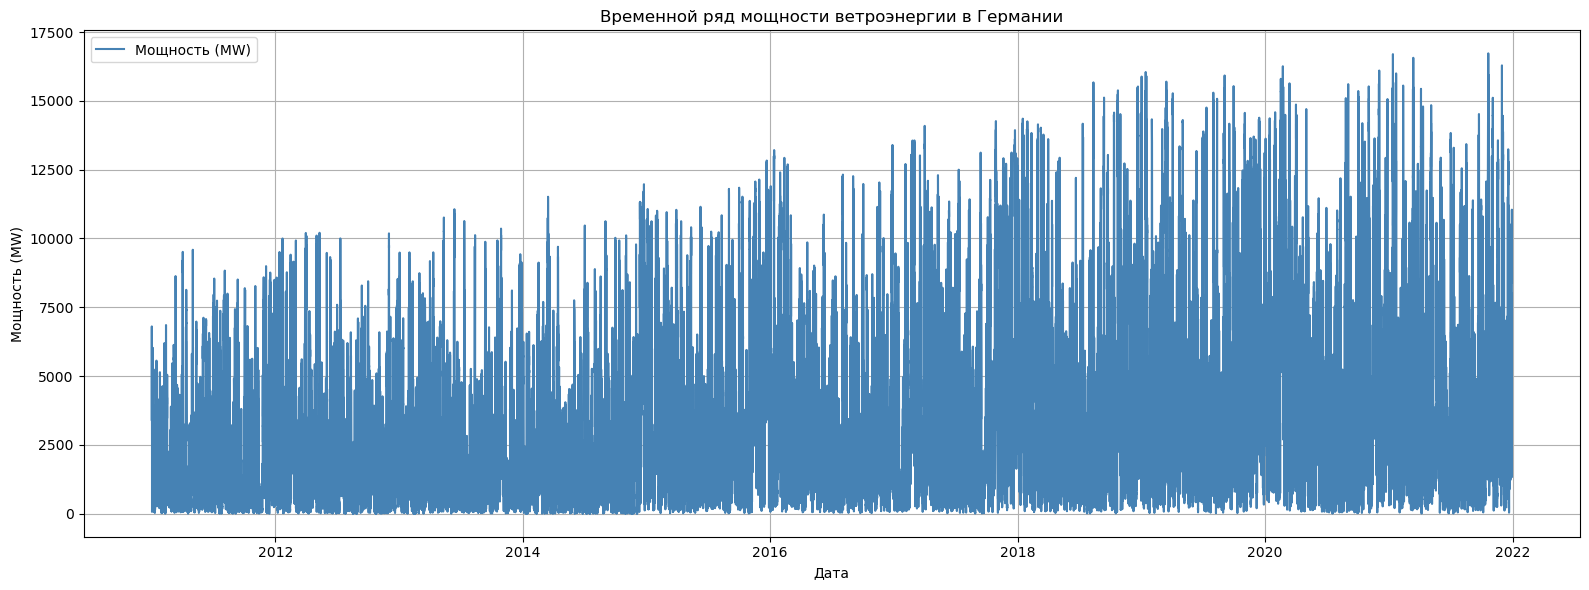

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['MW'], label='Мощность (MW)', color='steelblue')
plt.title('Временной ряд мощности ветроэнергии в Германии')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

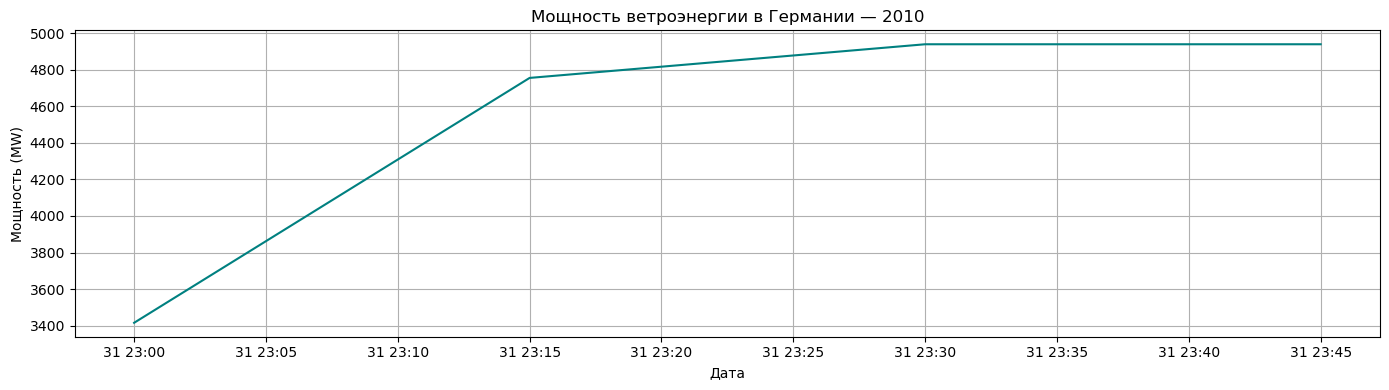

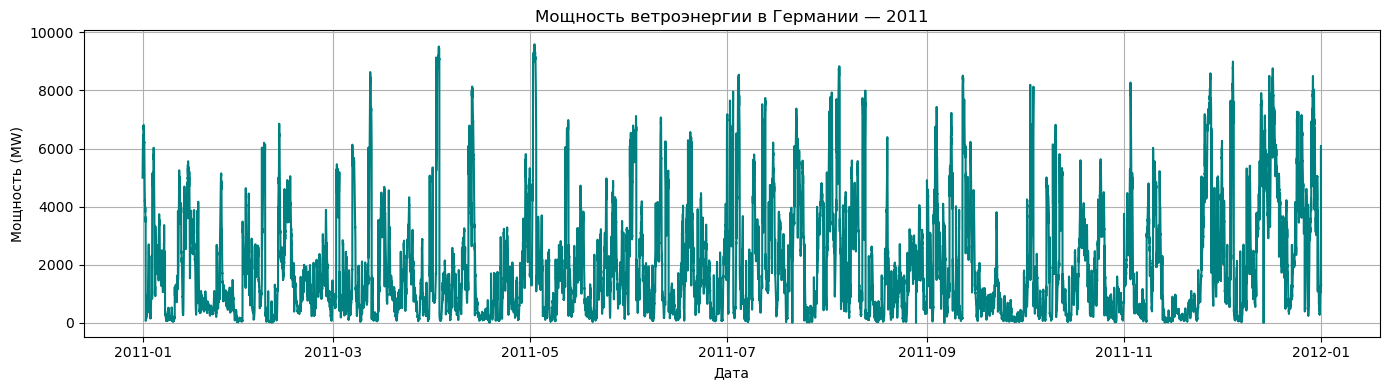

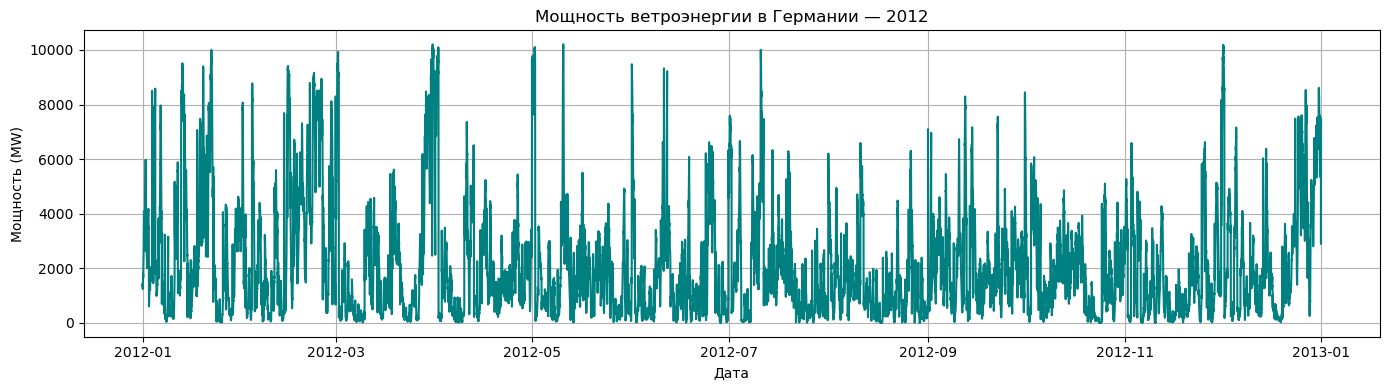

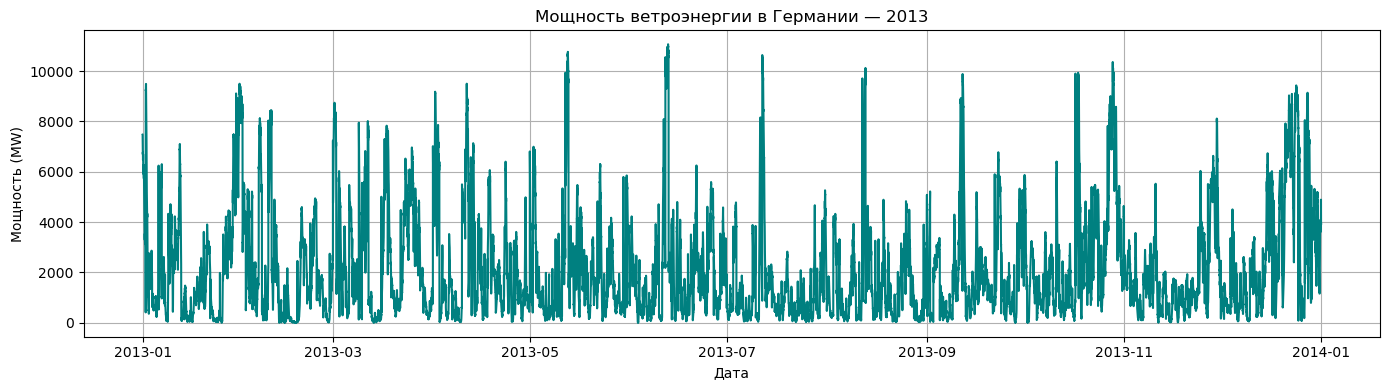

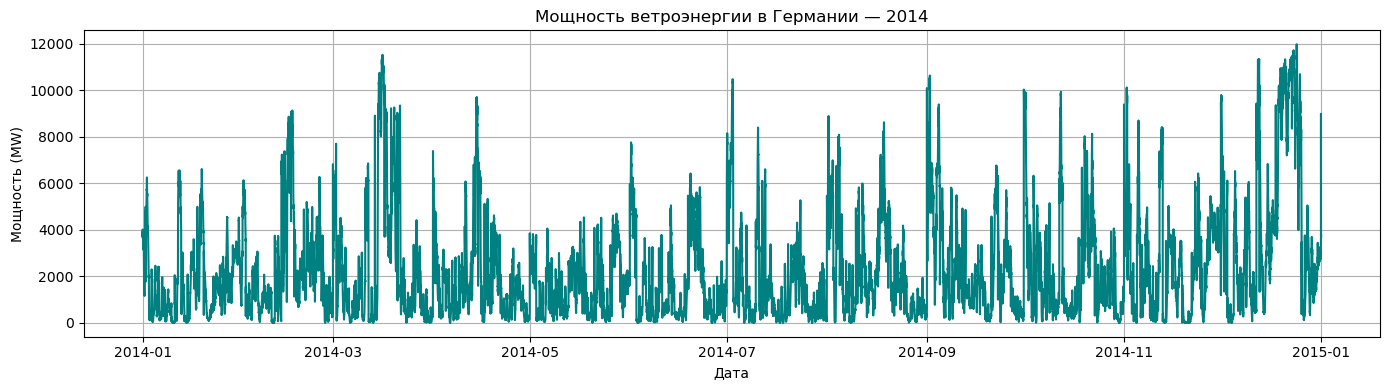

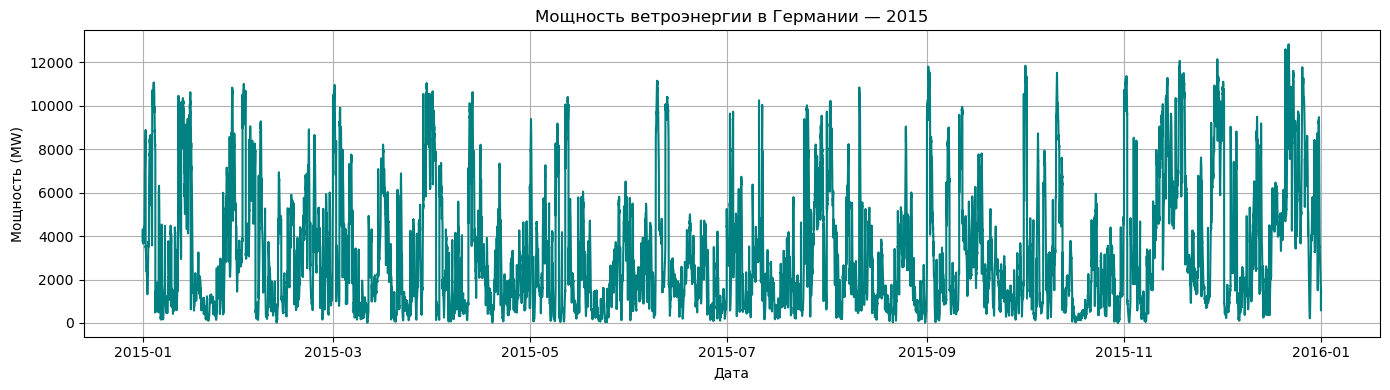

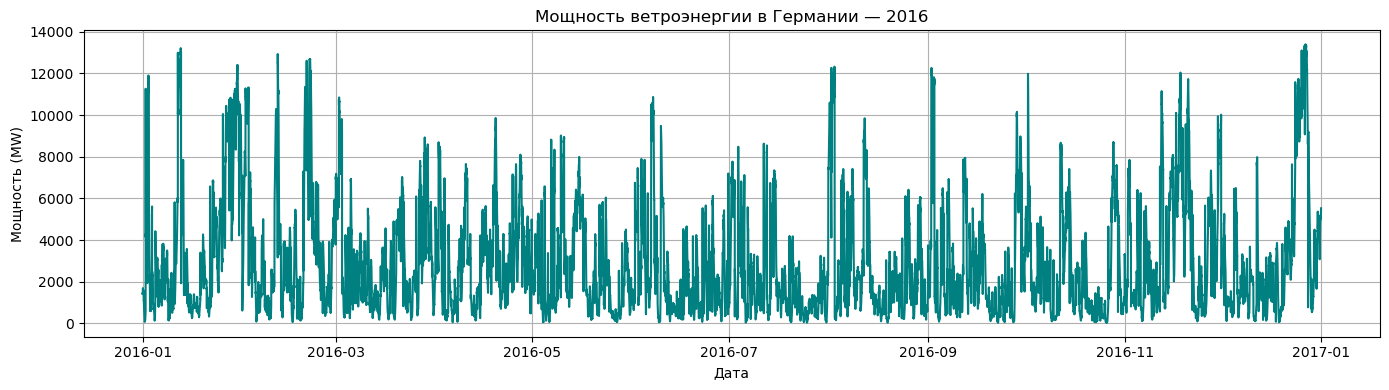

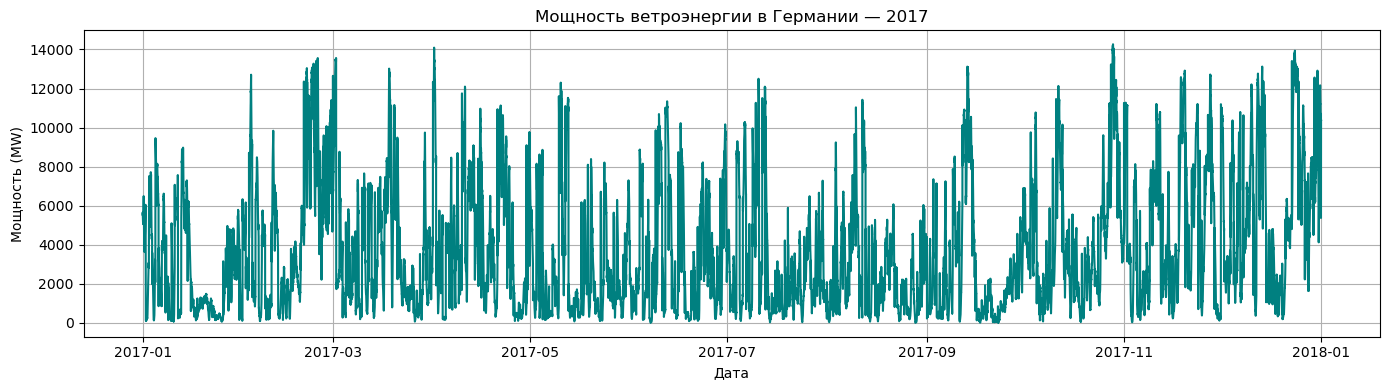

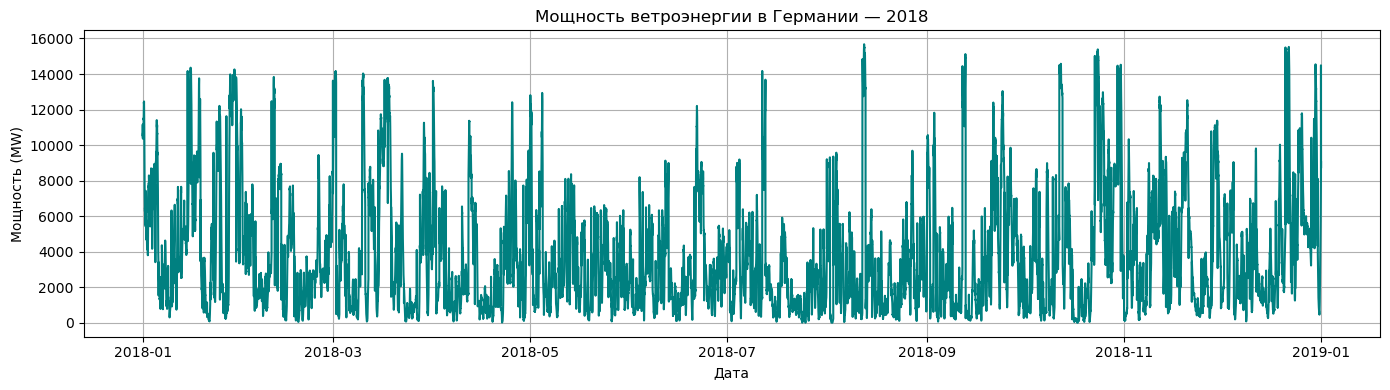

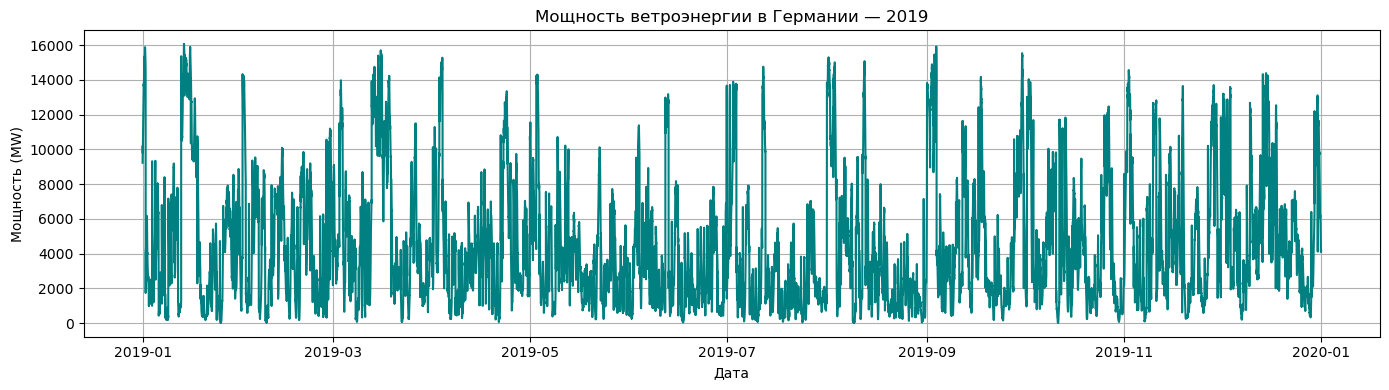

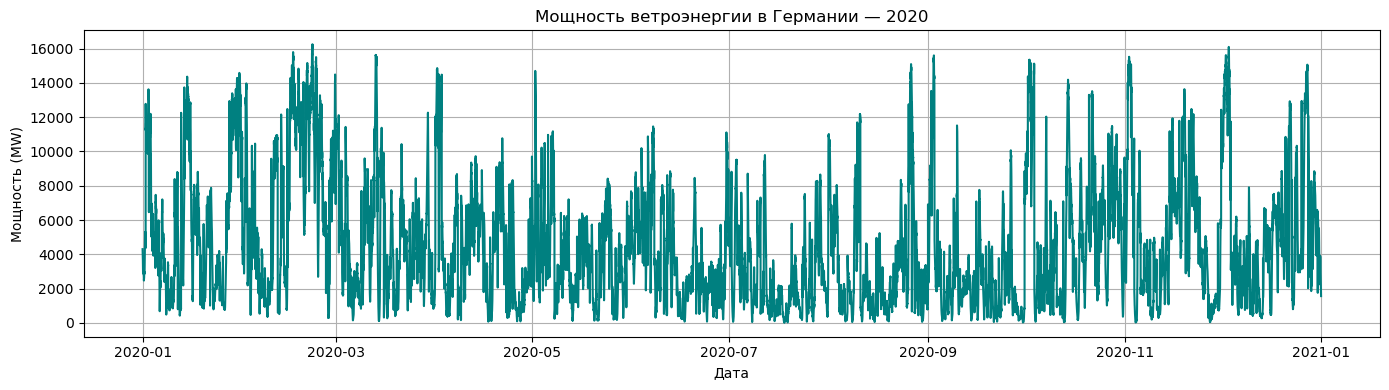

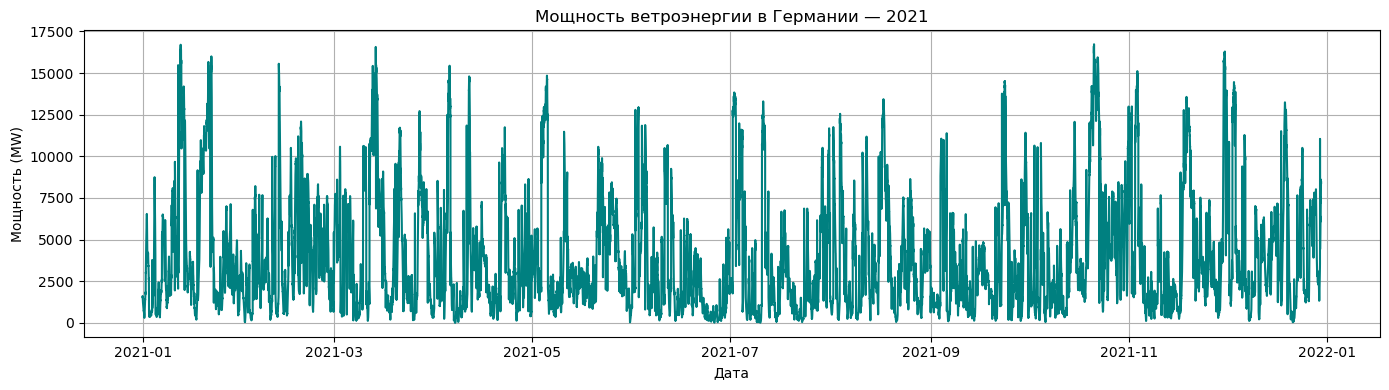

In [29]:
years = df.index.year.unique()

# Построим по 1 графику на каждый год
for year in sorted(years):
    df_year = df[df.index.year == year]

    plt.figure(figsize=(14, 4))
    plt.plot(df_year.index, df_year['MW'], label=f'{year}', color='teal')
    plt.title(f'Мощность ветроэнергии в Германии — {year}')
    plt.xlabel('Дата')
    plt.ylabel('Мощность (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385566 entries, 2010-12-31 23:00:00+00:00 to 2021-12-30 06:45:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MW      385566 non-null  float64
dtypes: float64(1)
memory usage: 13.9 MB


In [31]:
df['MW'].describe()

count    385566.000000
mean       3183.560481
std        3045.941591
min           0.000000
25%         905.000000
50%        2164.000000
75%        4529.877500
max       16727.500000
Name: MW, dtype: float64

In [32]:
4*24*365*12

420480

 - 385 566 записей — значит, данные почти полные за период 2011–2021, с разрешением в 15 минут (что ожидаемо: 4 точки в час × 24 часа × 365 дней × 12 лет  = 420480).
 - Средняя мощность — около 3183.56 МВт.
 - Стандартное отклонение очень высокое: 3045.94 МВт. Почти такое же большое, как среднее значение. Это значит, что ветряная генерация очень сильно колеблется от периода к периоду.
 - Минимальная мощность: 0 МВт. Есть периоды, когда ветряные турбины вообще не производили энергию (штиль или остановка турбин).
 - Большинство (50%) наблюдений находятся в диапазоне от 905 до 4530 МВт.
 - Медиана (2164) ниже средней (3183), значит: распределение немного смещено вправо (есть пики очень высоких значений).
 - Максимальная мощность: 16727.5 МВт. Это свидетельствует о пиковых нагрузках, когда ветрогенерация достигала очень высоких уровней в определённые моменты (например, сильные шторма).

In [33]:
# Коэффициент вариации
cv = df['MW'].std() / df['MW'].mean()
print(f"Коэффициент вариации (CV): {cv:.4f}")

Коэффициент вариации (CV): 0.9568


Ветряная генерация в Германии очень нестабильная,
Мощность ветра колеблется почти так же сильно, как и среднее значение,
Можно ожидать сильные пики и падения генерации в течение времени.

In [34]:
Q1 = df_final['MW'].quantile(0.25)
Q3 = df_final['MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_final[(df_final['MW'] < lower_bound) | (df_final['MW'] > upper_bound)]

print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers) / len(df_final) * 100:.2f}%")

Количество выбросов: 18036
Процент выбросов: 4.68%


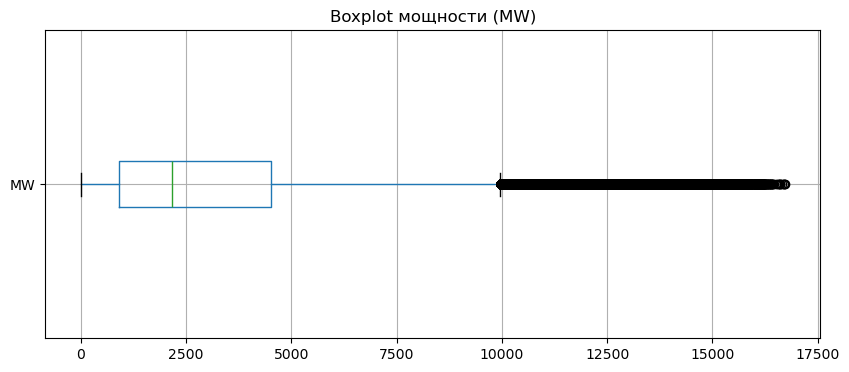

In [35]:
plt.figure(figsize=(10,4))
df.boxplot(column='MW', vert=False)
plt.title('Boxplot мощности (MW)')
plt.grid(True)
plt.show()

Количество выбросов нормальное (~4.7%),
Выбросы естественны для ветроэнергетики,
Можно спокойно продолжать анализ, учитывая высокую изменчивость.

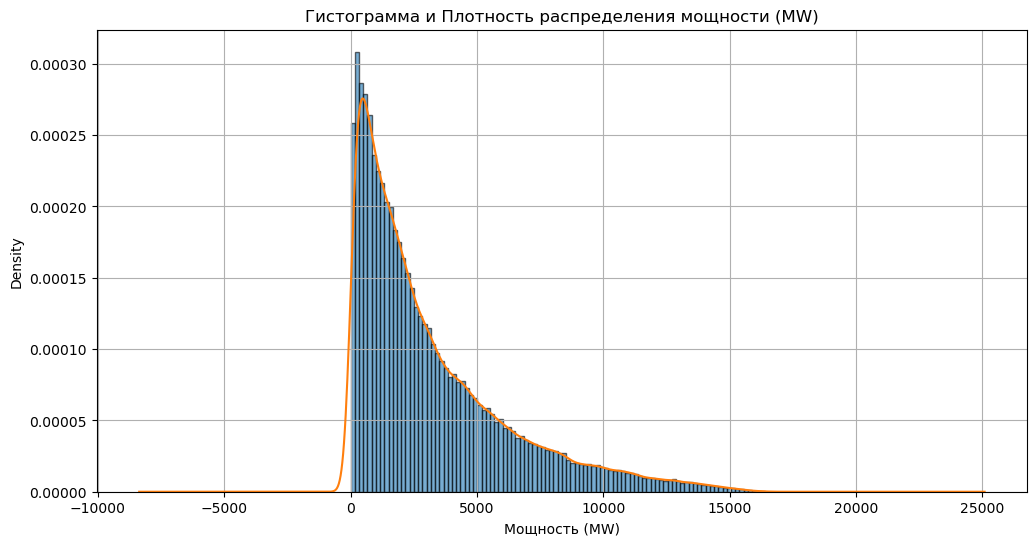

In [36]:
plt.figure(figsize=(12,6))
df['MW'].plot(kind='hist', bins=100, density=True, alpha=0.6, edgecolor='black')
df['MW'].plot(kind='kde')
plt.title('Гистограмма и Плотность распределения мощности (MW)')
plt.xlabel('Мощность (MW)')
plt.grid(True)
plt.show()

Основная масса значений сосредоточена ближе к нулю, резкий пик в начале (на малых мощностях), длинный правый хвост (значения до 15 000 МВт и выше).
Ветровая мощность в Германии за 2011–2021:
 - В основном низкая/средняя,
 - Иногда сильные всплески (связаны с погодными условиями),
 - Распределение сильно положительно асимметрично (heavy tail).

Для моделирования таких данных нельзя использовать методы, которые предполагают нормальность распределения (например, простую линейную регрессию без преобразований).

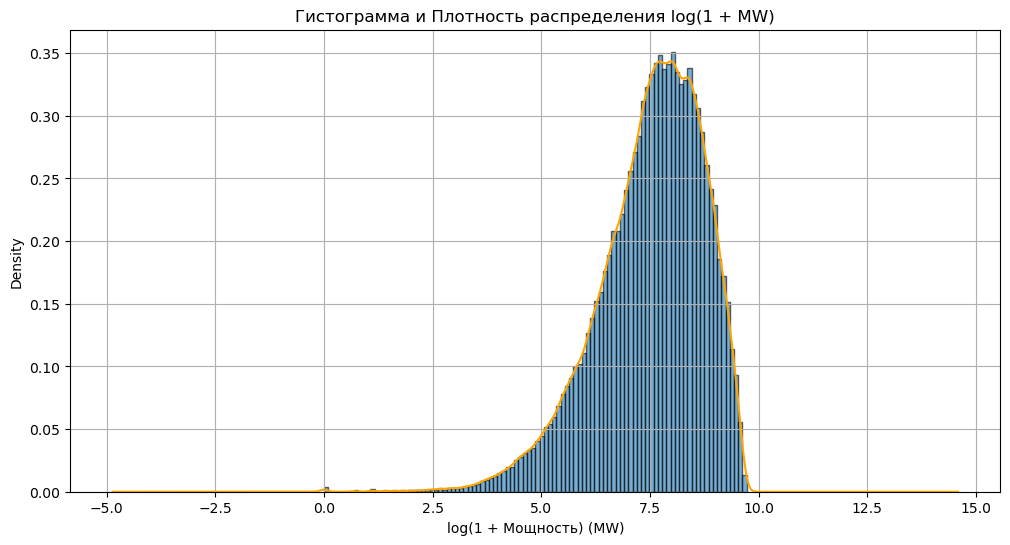

In [37]:
# Преобразуем мощность через log1p (логарифм от (1 + MW)), чтобы избежать log(0)
df['log_MW'] = np.log1p(df['MW'])

# Построим гистограмму и KDE для логарифма
plt.figure(figsize=(12,6))
df['log_MW'].plot(kind='hist', bins=100, density=True, alpha=0.6, edgecolor='black')
df['log_MW'].plot(kind='kde', color='orange')
plt.title('Гистограмма и Плотность распределения log(1 + MW)')
plt.xlabel('log(1 + Мощность) (MW)')
plt.grid(True)
plt.show()

 - Распределение стало намного более симметричным,
 - Основной пик сосредоточен в области от 7 до 8.5 (log(1 + MW)),
 - Хвост справа существенно сократился,
 - Больше нет длинного растянутого правого хвоста как на исходной мощности.

Теперь можно:
 - применять методы анализа, требующие нормальности (например, ARIMA, Prophet, линейные модели),
 - проще строить прогнозы,
 - легче обрабатывать экстремальные значения (пики не искажают модели).

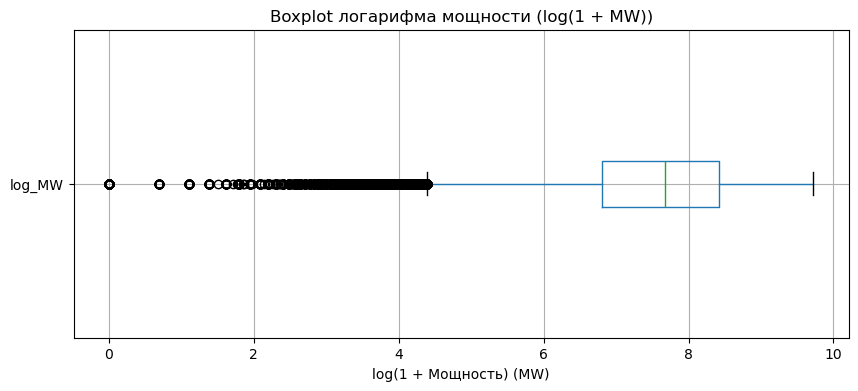

In [38]:
# Построим boxplot для логарифмированной мощности
plt.figure(figsize=(10, 4))
df.boxplot(column='log_MW', vert=False)
plt.title('Boxplot логарифма мощности (log(1 + MW))')
plt.xlabel('log(1 + Мощность) (MW)')
plt.grid(True)
plt.show()

 - Центральная часть (ящик) лежит примерно между 7 и 8.5,
 - Медиана (зелёная линия) чуть правее середины ящика - небольшая асимметрия вправо,
 - Много выбросов слева (0–6),
 - Правая граница (усы) доходит почти до 9.5.

Логарифмирование действительно сильно улучшило распределение:
распределение стало гораздо более упорядоченным и предсказуемым,
и выбросы теперь выглядят разумно.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Autocorrelation</h4>
</div>

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1200x600 with 0 Axes>

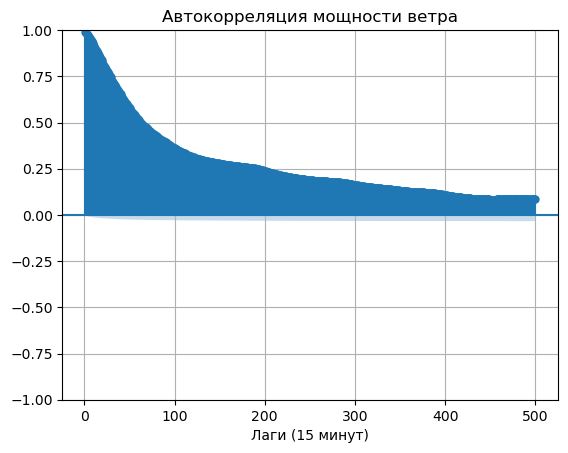

In [40]:
plt.figure(figsize=(12,6))
plot_acf(df['MW'].dropna(), lags=500, zero=False)
plt.title('Автокорреляция мощности ветра')
plt.xlabel('Лаги (15 минут)')
plt.grid(True)
plt.show()

Очень высокая автокорреляция на малых лагах (близких к нулю),
 - Автокорреляция медленно убывает,
 - Примерно к 500 лагу (500 × 15 мин = 5 суток) автокорреляция положительная (около 0.1–0.15).

 - Мощность ветрогенерации в Германии демонстрирует долгосрочную память,
 - Но нет чётких циклов типа ровно каждые сутки — вероятно, погодные условия меняются нерегулярно, не строго каждые 24 часа.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Augmented Dickey-Fuller test</h4>
</div>

In [41]:
from statsmodels.tsa.stattools import adfuller

In [42]:
result = adfuller(df['MW'].dropna())

print('ADF статистика:', result[0])
print('p-значение:', result[1])

ADF статистика: -43.07265917144701
p-значение: 0.0


Это означает, что мы уверенно отвергаем нулевую гипотезу (H₀):
ряд стационарен по Дики-Фуллеру.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> seasonal_decompose</h4>
</div>

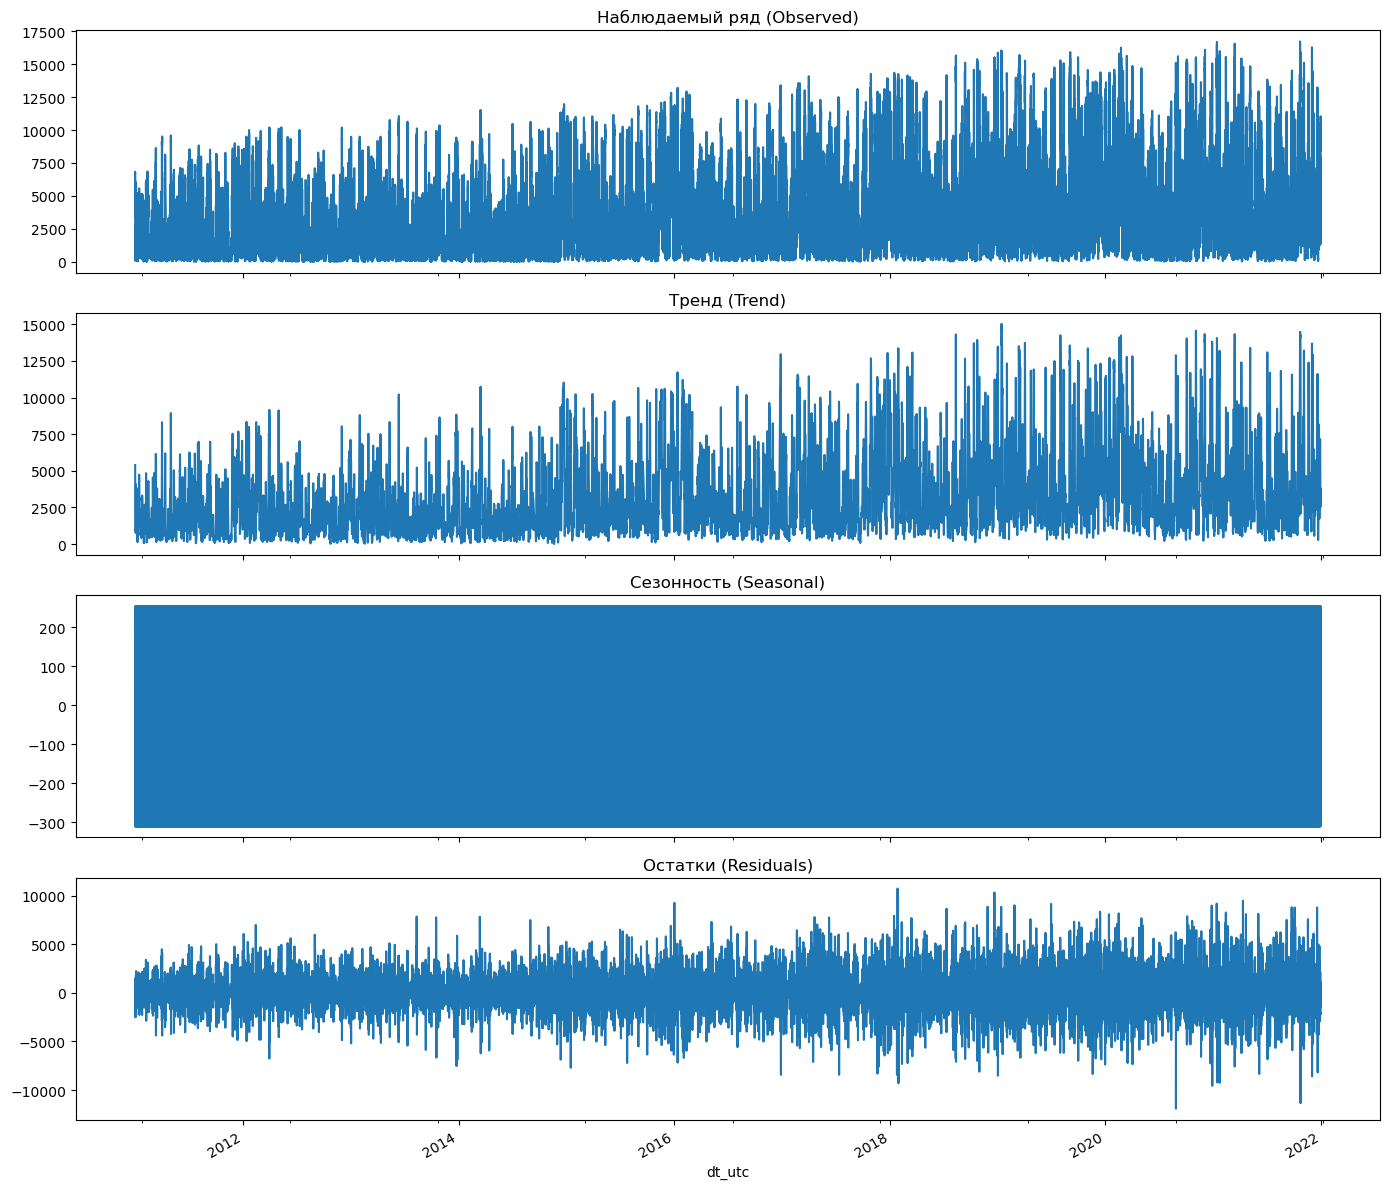

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Для разложения желательно использовать не log(MW), а обычные MW
# Но можно использовать и log(MW), чтобы сгладить хвосты
series_to_decompose = df['MW']

# Seasonal decomposition
decomposition = seasonal_decompose(series_to_decompose, model='additive', period=96)  # 96 лага = 1 день (24 часа)

# Построим графики
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Наблюдаемый ряд (Observed)')
decomposition.trend.plot(ax=axes[1], title='Тренд (Trend)')
decomposition.seasonal.plot(ax=axes[2], title='Сезонность (Seasonal)')
decomposition.resid.plot(ax=axes[3], title='Остатки (Residuals)')

plt.tight_layout()
plt.show()

Наблюдаемый ряд (Observed)
 - Видна сильная волатильность, особенно в 2019–2021.
 - В начале 2011–2013 выработка ниже → возможно, меньше турбин в сети.
 - Чёткой сезонной структуры на глаз не видно — тренд и шум смешиваются.

Тренд (Trend)
 - Примерно до 2015 года — умеренная активность.
 - С 2016 по 2022 — заметный рост средней мощности.
 - Это может указывать на увеличение установленной мощности (больше ветряков, выше выработка).

Сезонность (Seasonal)
 - почти ровный прямоугольник, seasonal_decompose не смог извлечь сезонность как ожидалось.
 - слишком большая доля шума и нестабильности, либо в ряде нет стабильной дневной повторяемости (что и логично для ветра).

 Остатки (Residuals)
 - видно, что дисперсия остатка тоже возрастает в последние годы (2018–2022),
 - значит, волатильность растёт — возможно, больше турбин и больше амплитуда колебаний.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> STL</h4>
</div>

In [44]:
from statsmodels.tsa.seasonal import STL

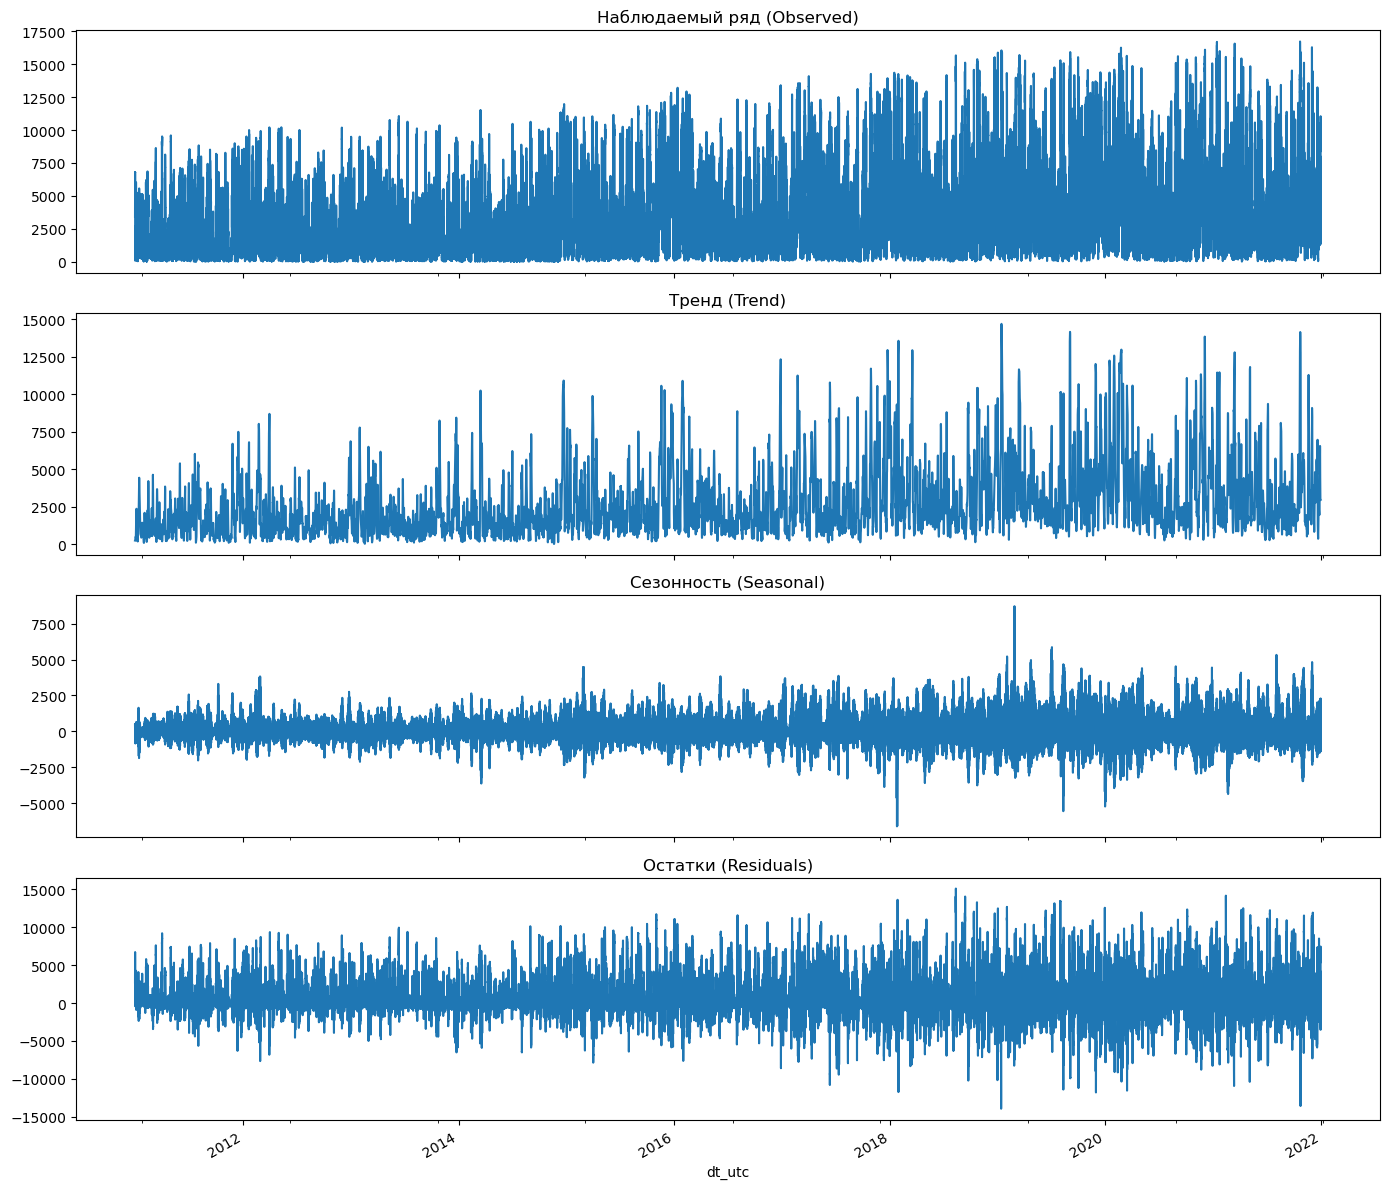

In [45]:
# Используем log-преобразованные данные для более стабильной сезонности
series_to_decompose = df['MW'].dropna()

# STL-разложение с дневной сезонностью (96 точек по 15 минут)
stl = STL(series_to_decompose, period=96, robust=True)
result = stl.fit()

# Визуализация
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

result.observed.plot(ax=axes[0], title='Наблюдаемый ряд (Observed)')
result.trend.plot(ax=axes[1], title='Тренд (Trend)')
result.seasonal.plot(ax=axes[2], title='Сезонность (Seasonal)')
result.resid.plot(ax=axes[3], title='Остатки (Residuals)')

plt.tight_layout()
plt.show()

Наблюдаемый ряд (Observed)
 - Плотный и хаотичный.
 - Увеличение мощности после 2016 года.

Тренд (Trend)
 - Более гладкий, чем в предыдущем методе,
 - Видно плавное увеличение установленной мощности в 2016–2021 гг.

Сезонность (Seasonal)
 - Видны циклы внутри каждого дня,
 - Амплитуда сезонных колебаний варьируется со временем, что реалистично для ветровой энергии.
 - STL смог извлечь суточную сезонность, учитывая изменение амплитуды и формы в течение лет.

 Остатки (Residuals)
 - Выглядят как случайный шум,
 - Но с видимой большей волатильностью в последние годы

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> Trend + Seasonal</h4>
</div>

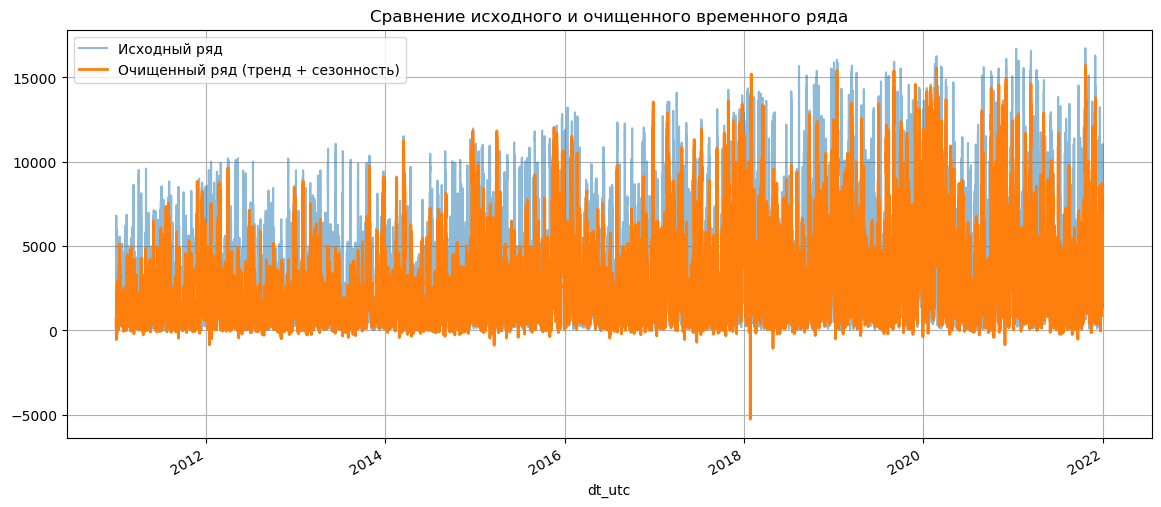

In [46]:
# Сумма тренда и сезонности = очищенный ряд
cleaned_series = result.trend + result.seasonal

plt.figure(figsize=(14,6))
result.observed.plot(label='Исходный ряд', alpha=0.5)
cleaned_series.plot(label='Очищенный ряд (тренд + сезонность)', linewidth=2)
plt.title('Сравнение исходного и очищенного временного ряда')
plt.legend()
plt.grid(True)
plt.show()

Выработка ветроэнергии в Германии растёт
 - Trend явно показывает плавный и устойчивый рост мощности с 2011 по 2021 год.
 - Это указывает на расширение инфраструктуры: больше ветряков, выше установленные мощности.

<div style='background-color: lightblue; padding: 10px; border-radius: 10px;'>
    <h4 style='color: darkblue;'> XGBoost</h4>
</div>

XGBoost не делает жёстких предположений о том, как должны выглядеть данные. Он просто учится на фактах: видит, что, например, если вчера вечером был сильный ветер, то и сегодня утром может быть что-то похожее. И наоборот: если было затишье, то и дальше может быть мало энергии. 
<br>В ходе анализа временного ряда мощности ветра за 2011–2021 годы было выявлено, что данные обладают высокой волатильностью, резкими колебаниями и отсутствием устойчивой, регулярной сезонности в чистом виде. 
<br>Статистический анализ показал:
 - Коэффициент вариации составил около 0.95, что указывает на сильную изменчивость данных.
 - По тесту Дики-Фуллера ряд оказался стационарным, но структура трендов и колебаний нестабильная по годам.

In [47]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [48]:
# Подготовка данных
df_ml = df[['MW']].resample('H').mean().dropna().reset_index()
df_ml.columns = ['ds', 'y']
df_ml['ds'] = df_ml['ds'].dt.tz_convert(None)

In [49]:
# Создание признаков
df_ml['hour'] = df_ml['ds'].dt.hour
df_ml['dayofweek'] = df_ml['ds'].dt.dayofweek
df_ml['month'] = df_ml['ds'].dt.month
df_ml['dayofyear'] = df_ml['ds'].dt.dayofyear
df_ml['hour_sin'] = np.sin(2 * np.pi * df_ml['hour'] / 24)
df_ml['hour_cos'] = np.cos(2 * np.pi * df_ml['hour'] / 24)
df_ml['dayofyear_sin'] = np.sin(2 * np.pi * df_ml['dayofyear'] / 365)
df_ml['dayofyear_cos'] = np.cos(2 * np.pi * df_ml['dayofyear'] / 365)

# Лаг-фичи
df_ml['lag_1'] = df_ml['y'].shift(1)    # Мощность 1 час назад
df_ml['lag_24'] = df_ml['y'].shift(24)  # Мощность сутки назад

In [50]:
# Логарифмирование цели
df_ml['log_y'] = np.log1p(df_ml['y'])
# Удаление строк с NaN после лагов
df_ml = df_ml.dropna()

In [51]:
# Деление на train/test
horizon = 24 * 365
train = df_ml.iloc[:-horizon]
test = df_ml.iloc[-horizon:]

In [52]:
features = [
    'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos',
    'dayofweek', 'month', 'lag_1', 'lag_24'
]

X_train, y_train = train[features], train['log_y']
X_test, y_test = test[features], test['log_y']

In [53]:
# Обучение XGBoost
model_xgb = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [54]:
# Предсказание
y_pred_log = model_xgb.predict(X_test)

In [55]:
# Обратная трансформация
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [56]:
# Метрики
rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = (abs((y_true - y_pred) / y_true).dropna() * 100).mean()
r2 = r2_score(y_true, y_pred)

In [57]:
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.4f}")

RMSE: 740.81
MAE: 406.45
MAPE: 14.65%
R2: 0.9536


 - Низкий RMSE (740.81 МВт). Ошибка прогноза в абсолютных величинах относительно небольшая по сравнению с типичными значениями мощности ветра (средняя мощность была около 3000 МВт).
 - Низкий MAE (406.45 МВт). Среднее отклонение между прогнозом и фактическими значениями также находится на очень хорошем уровне, указывая на высокую точность модели.
 - Невысокий MAPE (14.65%). Относительная ошибка ниже 20%, что считается отличным качеством для прогнозирования в реальных задачах, особенно в энергетике, где допустимыми обычно считаются ошибки до 20–30%.
 - Очень высокий R2 (0.9536). Модель объясняет около 95% всей изменчивости мощности ветра. Это говорит о том, что модель успешно захватила ключевые закономерности временного ряда.

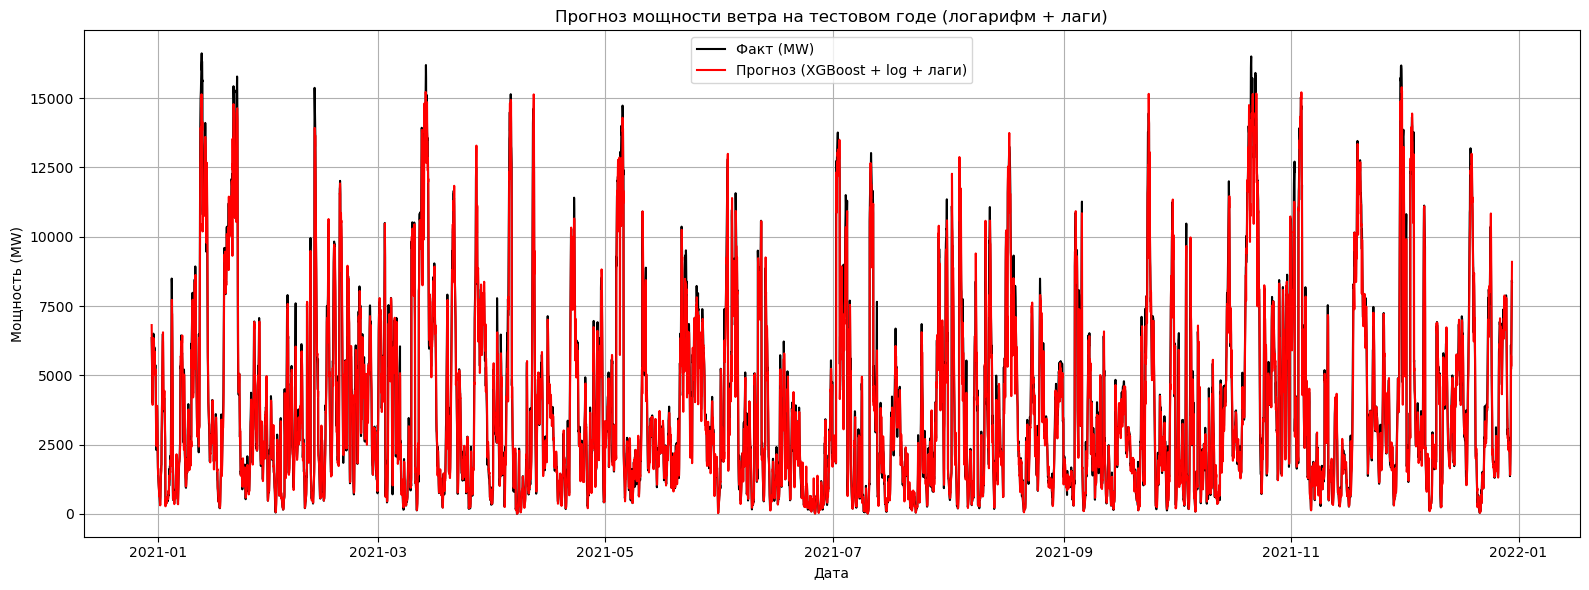

In [58]:
plt.figure(figsize=(16, 6))
plt.plot(test['ds'], y_true, label='Факт (MW)', color='black')
plt.plot(test['ds'], y_pred, label='Прогноз (XGBoost + log + лаги)', color='red')
plt.title('Прогноз мощности ветра на тестовом годе (логарифм + лаги)')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost отлично подошёл для прогноза мощности ветра, потому что он умеет работать с очень сложными, шумными данными, в которых трудно найти чёткие правила.
В такой ситуации оправдан выбор XGBoost (Extreme Gradient Boosting) по следующим причинам:
 - Гибкость модели: XGBoost не делает предположений о структуре данных. Он способен моделировать любые сложные зависимости за счёт построения ансамбля деревьев решений.
 - Устойчивость к выбросам и шуму: благодаря бустингу XGBoost корректно обрабатывает резкие скачки мощности, стабильно снижая ошибку.
 - Работа с лагами: после добавления признаков мощности за 1 час и 24 часа назад модель получила важную информацию о краткосрочной инерции ветрового процесса, что значительно повысило качество прогноза.
 - Логарифмирование целевой переменной: применение логарифмической трансформации привело к снижению влияния экстремальных значений и стабилизации обучения модели.

In [59]:
X_full, y_full = df_ml[features], df_ml['log_y']

In [60]:
model_xgb_full = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [61]:
model_xgb_full.fit(X_full, y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [62]:
last_date = df_ml['ds'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=24*365, freq='H')

In [63]:
future_df = pd.DataFrame({'ds': future_dates})

In [64]:
future_df['hour'] = future_df['ds'].dt.hour
future_df['dayofweek'] = future_df['ds'].dt.dayofweek
future_df['month'] = future_df['ds'].dt.month
future_df['dayofyear'] = future_df['ds'].dt.dayofyear
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
future_df['dayofyear_sin'] = np.sin(2 * np.pi * future_df['dayofyear'] / 365)
future_df['dayofyear_cos'] = np.cos(2 * np.pi * future_df['dayofyear'] / 365)


In [65]:
predictions = []
last_known = df_ml[['y']].copy()

In [66]:
for date in future_df['ds']:
    # Создаём запись для прогноза
    lag_1 = last_known.iloc[-1]['y']
    lag_24 = last_known.iloc[-24]['y'] if len(last_known) >= 24 else lag_1 

    row = future_df[future_df['ds'] == date].copy()
    row['lag_1'] = lag_1
    row['lag_24'] = lag_24

    # Прогнозируем log(y)
    X_pred = row[features]
    log_pred = model_xgb_full.predict(X_pred)[0]
    y_pred = np.expm1(log_pred)

    # Сохраняем
    predictions.append(y_pred)

    # Добавляем в last_known для следующих лагов
    last_known = pd.concat([last_known, pd.DataFrame({'y': [y_pred]}, index=[date])])


In [67]:
future_df['MW_forecast'] = predictions

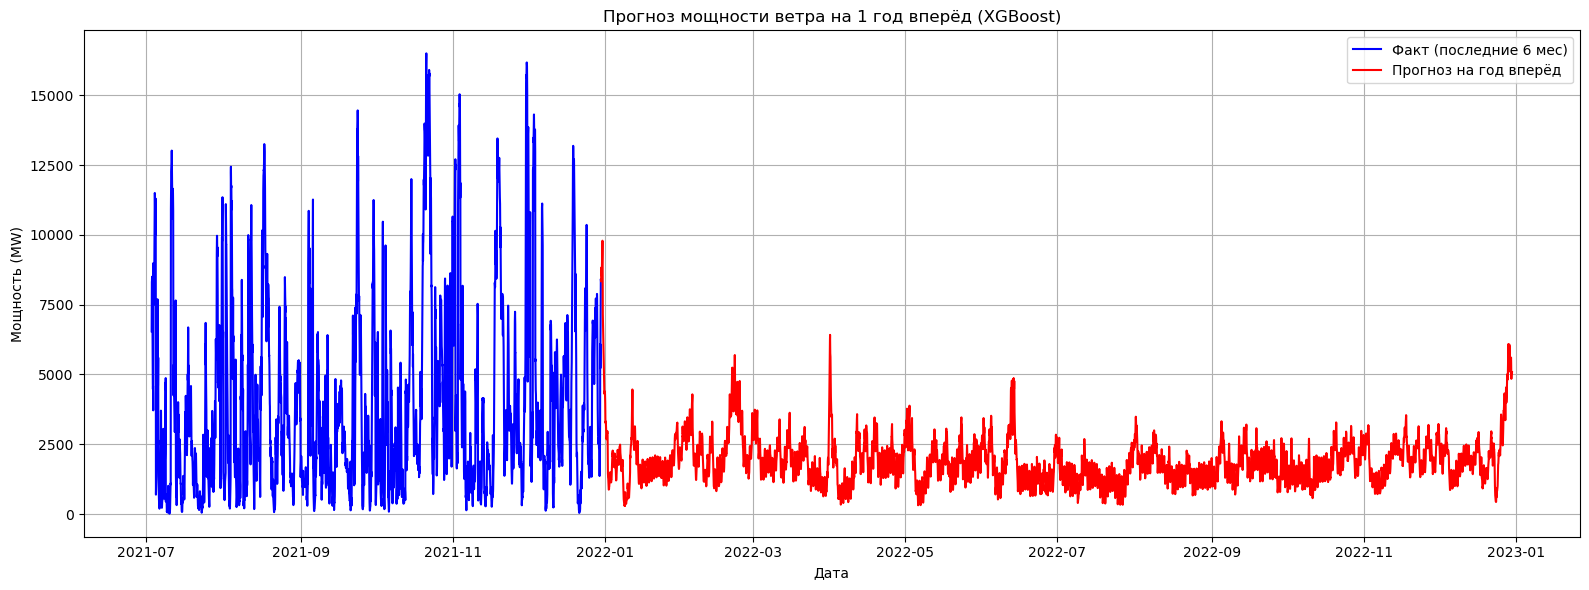

In [69]:
history_to_plot = df_ml[df_ml['ds'] >= df_ml['ds'].max() - pd.Timedelta(days=180)]

plt.figure(figsize=(16, 6))
plt.plot(history_to_plot['ds'], history_to_plot['y'], label='Факт (последние 6 мес)', color='blue')
plt.plot(future_df['ds'], future_df['MW_forecast'], label='Прогноз на год вперёд', color='red')
plt.title('Прогноз мощности ветра на 1 год вперёд (XGBoost)')
plt.xlabel('Дата')
plt.ylabel('Мощность (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Прогноз не показывает резких пиков, как в реальных данных. XGBoost, несмотря на высокое качество на тесте, склонна сглаживать экстремумы. Прогноз выглядит реалистично для планирования, но не для реактивного управления. Для улучшения - можно добавить данные о скорости ветра, давлении и др. погодных параметрах - тогда XGBoost сможет предсказывать всплески, а не только базовый уровень.